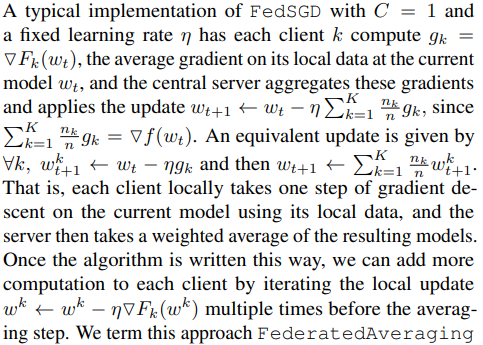

FedSGD는기존 로컬에서 모델을 학습하는 SGD 방법을 연합 학습에 적용한 것이다. 
FedSGD에서 필요한 하이퍼파라미터 C가 있다. 여기서 C는 사용자를 기준으로 하는 batch size를 말한다. 
예를 들어 C가 1인 경우 모든 사용자의 데이터를 사용하겠다는 의미이다. 
각 로컬에서 업데이트된 가중치는 아래식 같이 평균값을 계산하여 업데이트 된다. 
식에서 g는 gradient, w는 weight, η는 learning rate, n은 data의 수, 그리고 K는 사용자의 수를 말한다. 
FedSGD는 federated learning의 성능을 비교하기 위한 베이스라인으로 사용된다.
$$ w_{t+1} ← w_t − η\sum^{K}_{k=1} \frac{n_k}{n}g_k$$

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import copy
import numpy as np
import time
from ipynb.fs.full.FLDataset import load_dataset, getImgs, getData

In [3]:
class Arguments():
    def __init__(self):
        self.images = 60000 #총 이미지 수
        self.clients = 10 #총 클라이언트 수
        self.epochs = 50 #훈련 데이터 전체를 반복하는 횟수
        self.local_batches = self.images // self.clients #학습 한번에 불러올 데이터 크기
        self.lr = 0.1 #얼마나 빠르게 학습할 것인가?
        self.C = 1 #라운드에 얼마나 많은 클라이언트를 사용할 것인가
        self.torch_seed = 0 #랜덤 시드 고정
        self.log_interval = 10 #n번의 에포크 마다 학습 결과를 출력하기 위한 인자
        self.iid = 'iid' #iid환경에서의 테스트를 하기 위한 인자
        self.split_size = self.images // self.clients #60000/client 수 즉, 클라이언트 마다 할당되는 데이터의 수 
        self.samples = self.split_size / self.images #논문에서 정의하고 있는 샘플 크기 (nk/n)
        self.use_cuda = False
        self.save_model = False

#args라는 변수에 모두 저장되어있어 이후 코드에서 사용할 수 있음
args = Arguments()

use_cuda = args.use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
hook = sy.TorchHook(torch)
clients = []

#10개의 사전 데이터 형태를 생성하고 value에 VritualWorkder id: 값 client+i 를 생성한다.
for i in range(args.clients):
    clients.append({'fl': sy.VirtualWorker(hook, id="client{}".format(i+1))}) 
print(clients)

AttributeError: module 'syft' has no attribute 'TorchHook'

In [4]:
# 다운로드 MNIST
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid)
# 클라이언트 별로 데이터로더를 생성
for idx, client in enumerate(clients):
    trainset_idx_list = list(train_group[idx])
    client['trainset'] = getImgs(global_train, trainset_idx_list, args.local_batches) # 훈련 데이터 로더
    client['testset'] = getImgs(global_test, list(test_group[idx]), args.local_batches) #테스트 데이터 로더
    client['samples'] = len(trainset_idx_list) / args.images #추후 사용할 samples변수 정의

In [6]:
#getImgs하기 전 데이터 모양은 데이터셋 전체이기 때문에, 데이터 로더를 사용하여 전체 테스트 데이터셋 데이터 로더를 생성
global_test_loader = DataLoader(global_test, batch_size=args.local_batches, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) #input, output, kernel_size, stride
        
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #[-1, 50, 8,8]
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x shape[-1, 20, 24, 24]
        x = F.max_pool2d(x, 2, 2)
        # x shape[-1, 20, 12, 12] 
        x = F.relu(self.conv2(x))
        # x shape[-1, 50, 8, 8]
        x = F.max_pool2d(x, 2, 2)
        # x shape[-1, 50, 4, 4]
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        #x shape [-1, 500]
        x = self.fc2(x)
        #x shape [-1, 10]
        return F.log_softmax(x, dim=1)

In [8]:
def train(args, client, device, epoch):
    client['model'].train()
    client['model'].send(client['fl'])
    
    for batch_idx, (X, y) in enumerate(client['trainset']):
        #X와 Y를 불러오고 X와 y를 클라이언트에게 전송함
        X = X.send(client['fl'])
        y = y.send(client['fl'])        
        
        X, y = X.to(device), y.to(device)
        #학습 프로세스
        client['optim'].zero_grad() # 그라디언트 초기화
        output = client['model'](X) # 모델의 예측값 획득
        loss = F.nll_loss(output, y)
        loss.backward() #역전파
        client['optim'].step() #파라미터 업데이트
        client['model'].get()
         
        #loss를 출력하기 위한 출력문
        if batch_idx % args.log_interval == 0:
            loss = loss.get() 
            print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                client['fl'].id,
                epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                100. * batch_idx / len(client['trainset']), loss.item()))

In [9]:
def test(args, model, device, test_loader, name):
    model.eval()   
    test_loss = 0
    correct = 0
    with torch.no_grad():
        #test 데이터 로더를 불러와서 예측해보기
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += F.nll_loss(output, y, reduction='sum').item() #배치 로스 합
            pred = output.argmax(1, keepdim=True) # 결과 값으로 출력되는 log-probability를 클래스 숫자로 변경 [0,0,0,1,0,0,0]
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
def averageGradients(global_model, clients):
    client_models = [clients[i]['model'] for i in range(len(clients))]
    samples = [clients[i]['samples'] for i in range(len(clients))]

    for k in range(len(list(client_models[0].parameters()))):
        list(global_model.parameters())[k].grad = torch.stack([list(client_models[i].parameters())[k].grad.clone().detach() * samples[i] for i in range(len(client_models))], 0).sum(0)
    return global_model

In [11]:
class FedSGDOptim(optim.Optimizer): #SGD optimizer 수정
    def __init__(self, params, lr=args.lr):
        defaults = dict(lr=lr)
        super(FedSGDOptim, self).__init__(params, defaults)

    def step(self, grad_model=None, closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            for p in zip(group['params'], list(grad_model.parameters())): #p[0]: 갱신하기전 글로벌 모델 파라미터, 
                                                                         #p[1] : 클라이언트별 그라디언트의 평균을 구한 grad_model 파라미터
                if p[0].grad is None:
                    continue
                p[0].data.add_(-group['lr'], p[1].grad.data.clone().detach())  
          
        return loss

In [12]:
torch.manual_seed(args.torch_seed) # innitialize w0
global_model = Net().to(device) #initialize model
optimizer = FedSGDOptim(global_model.parameters(), lr=args.lr)
grad_model = Net().to(device)
#로컬 클라이언트 모델을 torch cpu에 로드 시키고 최적화함수를 해당 클라이언트 모델로 갱신하는 방식
#clients라는 사전에 모두 저장할 수 있도록 코드를 구성함
for client in clients:
    torch.manual_seed(args.torch_seed) 
    client['model'] = Net().to(device)
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    # 학습 진행
# 논문에서 학습 진행에 ClientUpdate함수가 사용되기때문에 이를 구현
for epoch in range(1, args.epochs +1):
    for client in clients:
        train(args, client, device, epoch)

    grad_model = averageGradients(global_model, clients)
    # Testing the average model
    test(args, global_model, device, global_test_loader, 'Global')
    optimizer.step(grad_model)
    test(args, global_model, device, global_test_loader, 'Global')

    # Share the global model with the clients
    for client in clients:
        client['model'].load_state_dict(global_model.state_dict())
        
if (args.save_model):
    torch.save(global_model.state_dict(), "FedSGD.pt")

/home/dilab/anaconda3/envs/pysyft/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/dilab/anaconda3/envs/pysyft/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client1 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.307624
Model client2 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.305924
Model client3 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.307482
Model client4 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.307878
Model client5 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.306867
Model client6 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.307319
Model client7 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.306916
Model client8 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.307337
Model client9 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.306760
Model client10 Train Epoch: 1 [0/6000 (0%)]	Loss: 2.305875

Test set: Average loss for Global model: 2.3064, Accuracy: 978/10000 (10%)



/home/dilab/anaconda3/envs/pysyft/lib/python3.7/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  response = method(*args, **kwargs)



Test set: Average loss for Global model: 2.3016, Accuracy: 996/10000 (10%)

Model client1 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302755
Model client2 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.301309
Model client3 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302652
Model client4 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.303009
Model client5 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302094
Model client6 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302500
Model client7 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302227
Model client8 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302548
Model client9 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.302080
Model client10 Train Epoch: 2 [0/6000 (0%)]	Loss: 2.301260

Test set: Average loss for Global model: 2.3016, Accuracy: 996/10000 (10%)


Test set: Average loss for Global model: 2.2969, Accuracy: 1082/10000 (11%)

Model client1 Train Epoch: 3 [0/6000 (0%)]	Loss: 2.298038
Model client2 Train Epoch: 3 [0/6000 (0%)]	Loss: 2.296837
Model client3 Train Epoch: 3 [0/6000 (0%)]	Loss: 2.297968
Model client4

Model client1 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.242157
Model client2 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.243120
Model client3 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.242796
Model client4 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.242265
Model client5 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.242738
Model client6 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.242840
Model client7 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.243920
Model client8 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.243099
Model client9 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.243658
Model client10 Train Epoch: 13 [0/6000 (0%)]	Loss: 2.242828

Test set: Average loss for Global model: 2.2413, Accuracy: 4448/10000 (44%)


Test set: Average loss for Global model: 2.2328, Accuracy: 5004/10000 (50%)

Model client1 Train Epoch: 14 [0/6000 (0%)]	Loss: 2.233669
Model client2 Train Epoch: 14 [0/6000 (0%)]	Loss: 2.234903
Model client3 Train Epoch: 14 [0/6000 (0%)]	Loss: 2.234455
Model client4 Train Epoch: 14 [0/6000 (0%)]	Loss: 2.233781
Model client5 Tra

Model client1 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.029498
Model client2 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.035890
Model client3 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.033644
Model client4 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.029825
Model client5 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.033036
Model client6 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.034804
Model client7 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.038209
Model client8 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.033040
Model client9 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.038107
Model client10 Train Epoch: 24 [0/6000 (0%)]	Loss: 2.033386

Test set: Average loss for Global model: 2.0279, Accuracy: 6728/10000 (67%)


Test set: Average loss for Global model: 1.9813, Accuracy: 6742/10000 (67%)

Model client1 Train Epoch: 25 [0/6000 (0%)]	Loss: 1.983310
Model client2 Train Epoch: 25 [0/6000 (0%)]	Loss: 1.990659
Model client3 Train Epoch: 25 [0/6000 (0%)]	Loss: 1.988095
Model client4 Train Epoch: 25 [0/6000 (0%)]	Loss: 1.983718
Model client5 Tra

Model client1 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.080917
Model client2 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.099736
Model client3 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.093827
Model client4 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.096444
Model client5 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.089430
Model client6 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.098937
Model client7 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.105768
Model client8 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.083702
Model client9 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.106593
Model client10 Train Epoch: 35 [0/6000 (0%)]	Loss: 1.086747

Test set: Average loss for Global model: 1.0677, Accuracy: 7828/10000 (78%)


Test set: Average loss for Global model: 0.9770, Accuracy: 7945/10000 (79%)

Model client1 Train Epoch: 36 [0/6000 (0%)]	Loss: 0.991956
Model client2 Train Epoch: 36 [0/6000 (0%)]	Loss: 1.012040
Model client3 Train Epoch: 36 [0/6000 (0%)]	Loss: 1.007980
Model client4 Train Epoch: 36 [0/6000 (0%)]	Loss: 1.010690
Model client5 Tra

Model client1 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.265415
Model client2 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.286130
Model client3 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.261904
Model client4 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.291422
Model client5 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.265467
Model client6 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.278713
Model client7 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.296142
Model client8 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.259292
Model client9 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.288442
Model client10 Train Epoch: 46 [0/6000 (0%)]	Loss: 1.279447

Test set: Average loss for Global model: 1.2574, Accuracy: 7285/10000 (73%)


Test set: Average loss for Global model: 1.1496, Accuracy: 7434/10000 (74%)

Model client1 Train Epoch: 47 [0/6000 (0%)]	Loss: 1.158767
Model client2 Train Epoch: 47 [0/6000 (0%)]	Loss: 1.179474
Model client3 Train Epoch: 47 [0/6000 (0%)]	Loss: 1.156707
Model client4 Train Epoch: 47 [0/6000 (0%)]	Loss: 1.185777
Model client5 Tra

In [13]:
optimizer??